In [1]:
cd DAMO-YOLO

/home/test/carasml/detection/damo/DAMO-YOLO


/home/test/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Create Dataset

The dataset GC10-Det should have downloaded already <br>
if you cannot find it in DAMO-YOLO/datasets/ <br>
download dataset from https://datasetninja.com/gc10-det <br>
(or use the attached file named with "eyJsaW")  <br>
unzip <br>
put the folder 'dc' under DAMO-YOLO/datasets/ <br>
and rename it as 'GC10-Det'

refer to official tutorial https://github.com/tinyvision/DAMO-YOLO/blob/master/assets/CustomDatasetTutorial.md

the dataset should be in coco format saved in json, includes three necessary feilds, i.e., image, annotation, categories. Here is an example

In [2]:
# We make train test split
import os
import shutil
import random

# Base directory
base_dir = 'datasets/GC10-Det'

# Original annotation and image folders
ann_dir = os.path.join(base_dir, 'ann')
img_dir = os.path.join(base_dir, 'img')

# Output directories to create
dirs_to_create = [
    os.path.join(base_dir, "train", "img"),
    os.path.join(base_dir, "train", "ann"),
    os.path.join(base_dir, "valid", "img"),
    os.path.join(base_dir, "valid", "ann")
]

# Create output directories
for d in dirs_to_create:
    os.makedirs(d, exist_ok=True)

# Train-validation split ratio
train_ratio = 0.8
random.seed(42)

# Collect all annotation file names
json_files = sorted([f for f in os.listdir(ann_dir) if f.endswith('.json')])
random.shuffle(json_files)

# Split into train and validation
split_index = int(train_ratio * len(json_files))
train_jsons = json_files[:split_index]
valid_jsons = json_files[split_index:]

# Helper to move paired files
def move_files(json_list, split):
    for json_name in json_list:
        img_name = os.path.splitext(json_name)[0]

        src_ann = os.path.join(ann_dir, json_name)
        dst_ann = os.path.join(base_dir, split, "ann", json_name)

        src_img = os.path.join(img_dir, img_name)
        dst_img = os.path.join(base_dir, split, "img", img_name)

        if os.path.exists(src_img):
            shutil.copy2(src_img, dst_img)
        else:
            print(f"⚠️ Image not found: {src_img}")

        if os.path.exists(src_ann):
            shutil.copy2(src_ann, dst_ann)
        else:
            print(f"⚠️ Annotation not found: {src_ann}")

# Move files
move_files(train_jsons, 'train')
move_files(valid_jsons, 'valid')

print("✅ Done: Dataset split into train/ and valid/")


✅ Done: Dataset split into train/ and valid/


In [3]:
# convert to unified coco json format
classes = ['crease', 'crescent_gap', 'inclusion', 'oil_spot', 'punching_hole',
           'rolled_pit', 'silk_spot', 'waist folding', 'water_spot', 'welding_line']
class_name_to_id = {name: idx for idx, name in enumerate(classes)}

import os
import json
from collections import defaultdict

def convert_to_coco(json_directory, output_path, classes):
    class_name_to_id = {name: idx for idx, name in enumerate(classes)}
    file_list = [f for f in os.listdir(json_directory) if f.endswith('.json')]
    
    data_dict = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": idx, "name": name} for idx, name in enumerate(classes)
        ]
    }
    
    next_image_id = 0
    next_annotation_id = 0

    for json_filename in file_list:
        json_path = os.path.join(json_directory, json_filename)
        
        with open(json_path, 'r') as file:
            try:
                data = json.load(file)
                
                # Create image entry
                image_info = {
                    "id": next_image_id,
                    "file_name": json_filename.replace('.json', ''),  # or .png
                    "height": data.get("size", {}).get("height", 0),
                    "width": data.get("size", {}).get("width", 0)
                }
                data_dict["images"].append(image_info)
                
                # Annotations
                for obj in data.get("objects", []):
                    class_title = obj.get("classTitle", "unknown")
                    if class_title not in class_name_to_id:
                        continue
                    
                    category_id = class_name_to_id[class_title]
                    points = obj.get("points", {})
                    exterior = points.get("exterior", [])
                    
                    if not exterior:
                        continue
                    
                    x_coords = [p[0] for p in exterior]
                    y_coords = [p[1] for p in exterior]
                    x_min = min(x_coords)
                    y_min = min(y_coords)
                    width = max(x_coords) - x_min
                    height = max(y_coords) - y_min
                    
                    annotation = {
                        "id": next_annotation_id,
                        "image_id": next_image_id,
                        "category_id": category_id,
                        "category_name": class_title,
                        "bbox": [x_min, y_min, width, height],
                        "area": width * height,
                        #"segmentation": [sum([[p[0], p[1]] for p in exterior], [])],
                        "iscrowd": 0
                    }
                    data_dict["annotations"].append(annotation)
                    next_annotation_id += 1
                
                next_image_id += 1
            except Exception as e:
                print(f"⚠️ Failed to read {json_path}: {e}")
    
    with open(output_path, 'w') as f:
        json.dump(data_dict, f, indent=2)
    print(f"✅ COCO annotations saved to: {output_path}")

convert_to_coco(
    json_directory=os.path.join(base_dir, 'train', 'ann'),
    output_path=os.path.join(base_dir, 'train', 'ann', 'annotations.json'),
    classes=classes
)

convert_to_coco(
    json_directory=os.path.join(base_dir, 'valid', 'ann'),
    output_path=os.path.join(base_dir, 'valid', 'ann', 'annotations.json'),
    classes=classes
)

✅ COCO annotations saved to: datasets/GC10-Det/train/ann/annotations.json
✅ COCO annotations saved to: datasets/GC10-Det/valid/ann/annotations.json


After the above preprocessing, the dataset should be in below structure
```
GC10-Det
    ├── train
    │   ├── img
    │   │   ├── image1
    │   │   └── image2
    │   └── ann
    │       └── annotations.json
    └── valid
        ├── img
        │   ├── image1
        │   └── image2
        └── ann
            └── annotations.json
```

You can also use your own dataset. If you have not label a dataset yet, you can use LabelImg to label. Please choose PascalVOC format.<br>
If your dataset is labeled by LabelImg, you can run the below script to convert annotations to required format <br>
Remember to move the files so the dataset is in above mentioned structure

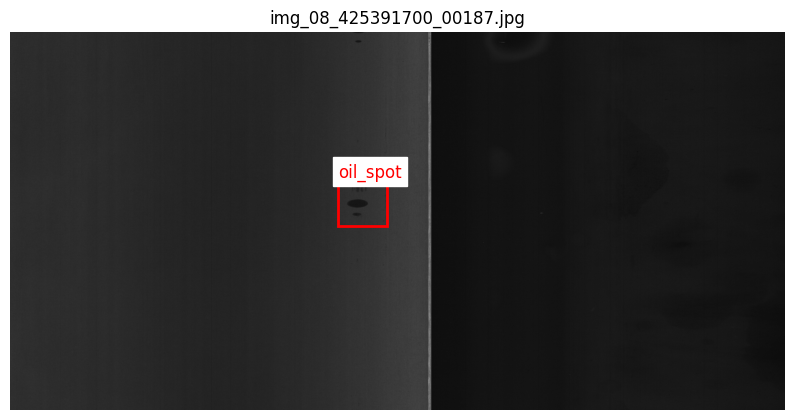

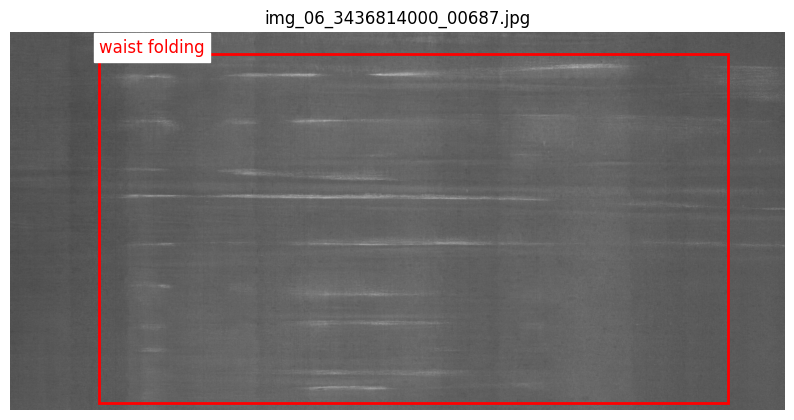

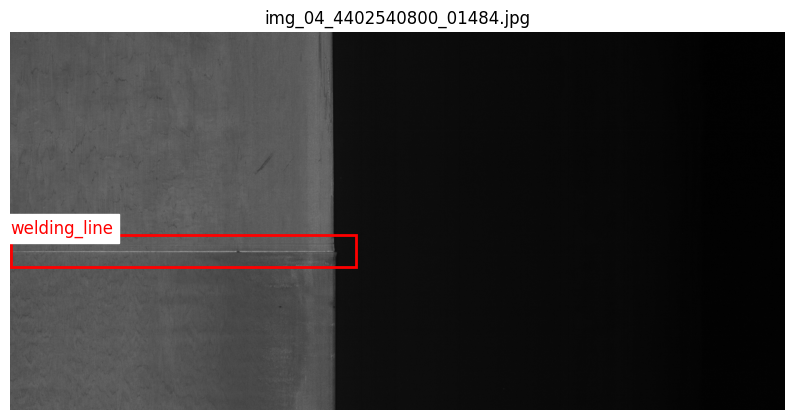

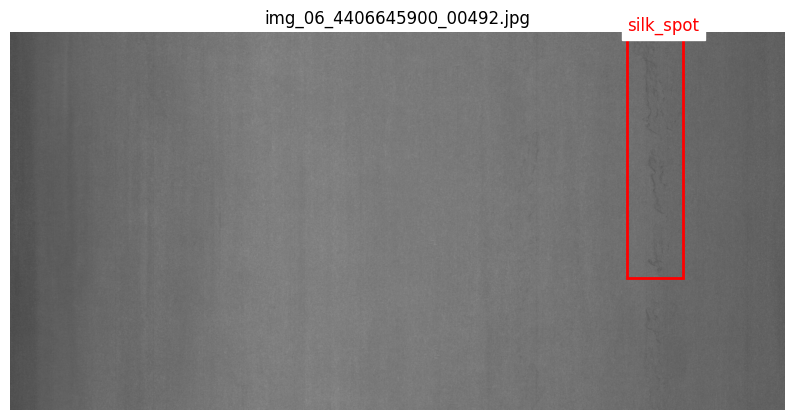

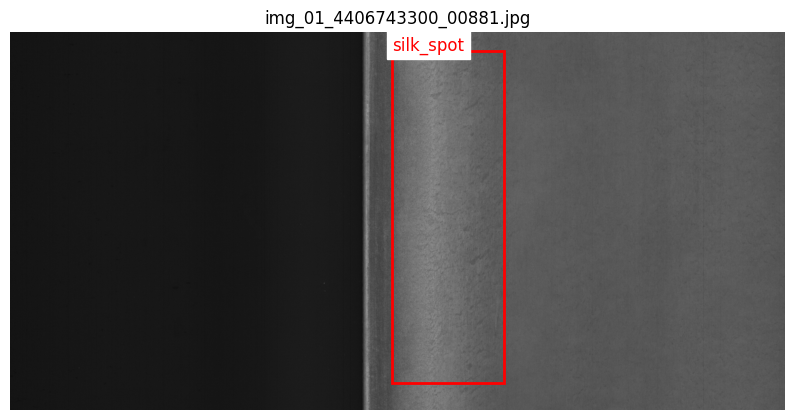

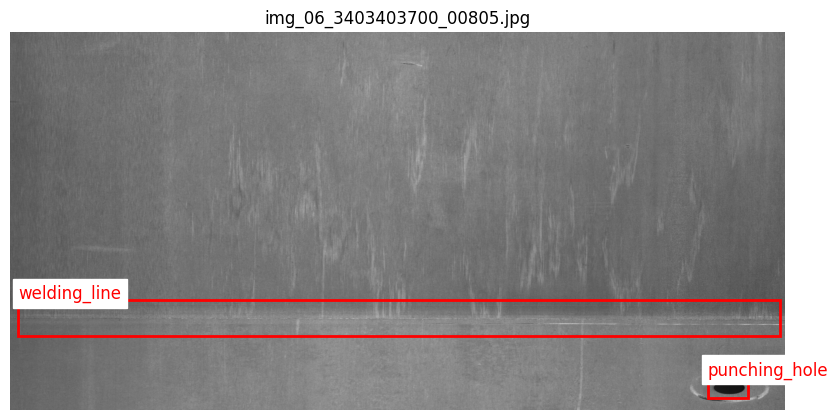

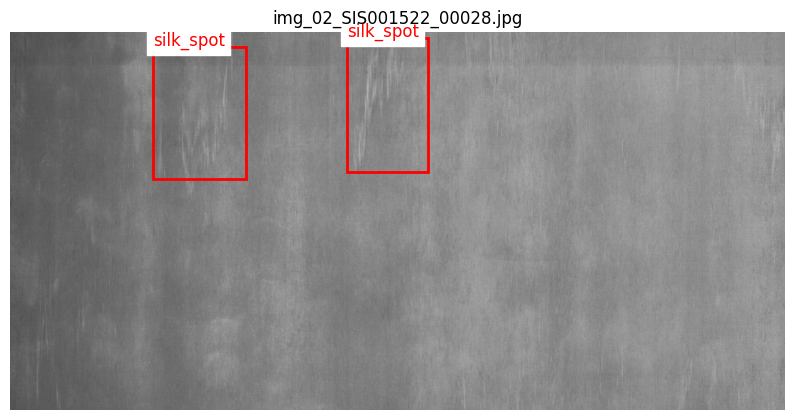

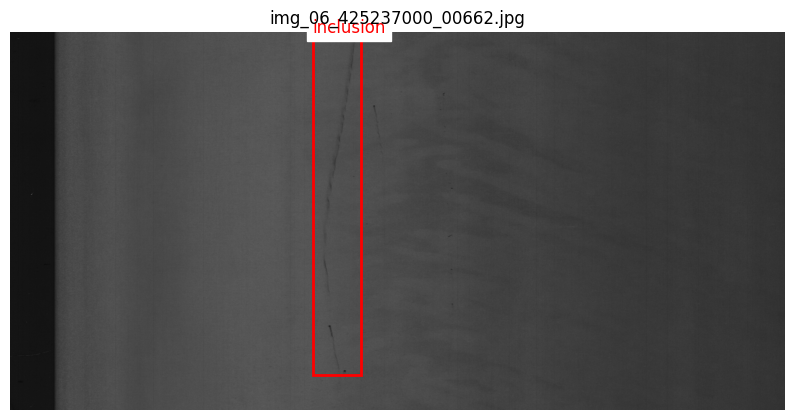

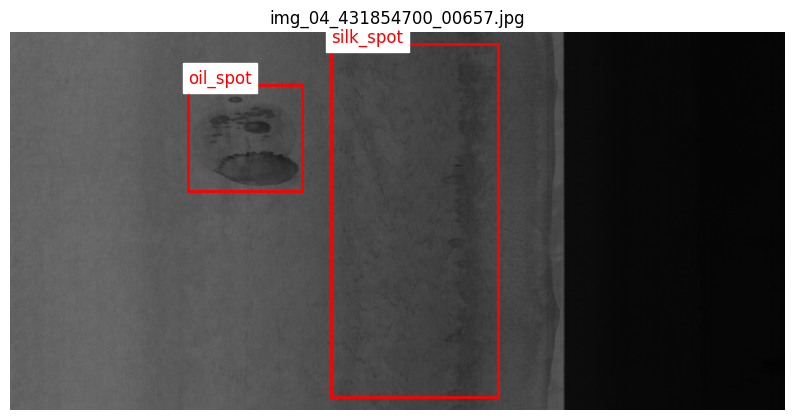

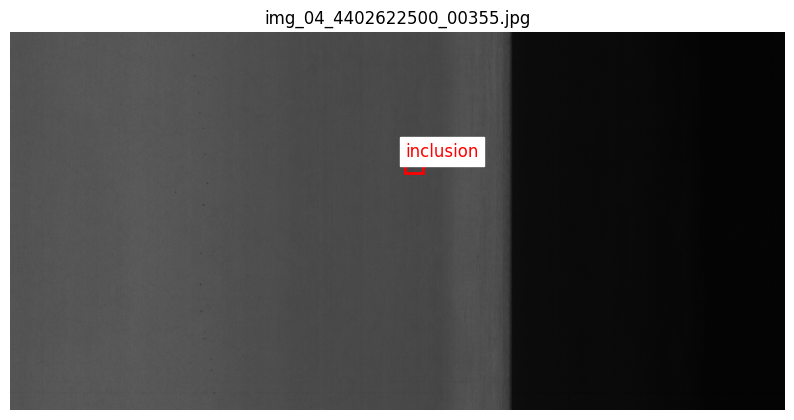

In [4]:
# plot some samples
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot(image_dir, annotation_path, num_images=10):
    # Load COCO-style JSON
    with open(annotation_path, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']
    categories = {cat['id']: cat['name'] for cat in data['categories']}

    # Map image_id -> list of annotations
    ann_map = {}
    for ann in annotations:
        ann_map.setdefault(ann['image_id'], []).append(ann)

    # Randomly sample images
    sample_images = random.sample(images, min(num_images, len(images)))

    # Plot
    for img_meta in sample_images:
        img_path = os.path.join(image_dir, img_meta['file_name'])
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue

        img = Image.open(img_path).convert("RGB")
        fig, ax = plt.subplots(1, figsize=(10, 8))
        ax.imshow(img)
        ax.set_title(img_meta['file_name'])

        # Draw boxes if available
        anns = ann_map.get(img_meta['id'], [])
        for ann in anns:
            bbox = ann['bbox']
            category_id = ann['category_id']
            label = categories.get(category_id, 'unknown')

            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(
                bbox[0], bbox[1] - 5, label,
                fontsize=12, color='red', backgroundcolor='white'
            )

        plt.axis('off')
        plt.show()

# Example usage:
plot(
    image_dir='datasets/GC10-Det/train/img',
    annotation_path='datasets/GC10-Det/train/ann/annotations.json',
    num_images=10
)
# some defects were omitted, dont do that!!

# Training

Please open damo/config/paths_catalog.py to revise the directory of images and annotation json <br>
Or run the below code to assign directory for our demo dataset

In [5]:
config = """
import os

class DatasetCatalog(object):
    DATA_DIR = 'datasets'
    DATASETS = {
        'coco_2017_train': {
            'img_dir': 'GC10-Det/train/img', # image directory
            'ann_file': 'GC10-Det/train/ann/annotations.json' # annotation json directory
        },
        'coco_2017_val': {
            'img_dir': 'GC10-Det/valid/img', # image directory
            'ann_file': 'GC10-Det/valid/ann/annotations.json' # annotation json directory
        },
        }

    @staticmethod
    def get(name):
        if 'coco' in name:
            data_dir = DatasetCatalog.DATA_DIR
            attrs = DatasetCatalog.DATASETS[name]
            args = dict(
                root=os.path.join(data_dir, attrs['img_dir']),
                ann_file=os.path.join(data_dir, attrs['ann_file']),
            )
            return dict(
                factory='COCODataset',
                args=args,
            )
        else:
            raise RuntimeError('Only support coco format now!')
        return None
"""
with open('./damo/config/paths_catalog.py', 'w') as f:
    f.write(config)

Please download a pretrained model from https://github.com/tinyvision/DAMO-YOLO <br>
which you will get something like 'damoyolo_nano_small.pth' <br>
Put the .pth under current directory /DAMO-YOLO <br>
Unfortunately the links may be dead sometimes, so we have attached some pth in current directory <br>
 <br>
Please create a copy of configs/damoyolo_tinynasL18_Ns.py and name it as damoyolo_tinynasL18_Ns-GC10.py <br>
Make these changes <br>
line 17: self.train.batch_size #fit in 1 gpu <br>
line 77: 'num_classes': <br>
line 89: self.dataset.class_names  <br>
Or run the below code to finish the adjustment for our demo dataset

In [6]:
config = """
#!/usr/bin/env python3

import os

from damo.config import Config as MyConfig


class Config(MyConfig):
    def __init__(self):
        super(Config, self).__init__()

        self.miscs.exp_name = os.path.split(
            os.path.realpath(__file__))[1].split('.')[0]
        self.miscs.eval_interval_epochs = 10
        self.miscs.ckpt_interval_epochs = 10
        # optimizer
        self.train.total_epochs = 100 # set number of epoch 
        self.train.batch_size = 64
        self.train.base_lr_per_img = 0.001 / 64
        self.train.min_lr_ratio = 0.05
        self.train.no_aug_epochs = 32
        self.train.warmup_epochs = 5
        self.train.finetune_path ='damoyolo_nano_small.pth' # your downloaded model .pth ,or delete the line if not start with pretrained model

        self.train.optimizer = {
            'name': "AdamW",
            'weight_decay': 1e-2,
            'lr': 4e-3,
            }

        # augment
        self.train.augment.transform.image_max_range = (416, 416)
        self.train.augment.transform.keep_ratio = False
        self.test.augment.transform.keep_ratio = False
        self.test.augment.transform.image_max_range = (416, 416)
        self.train.augment.mosaic_mixup.mixup_prob = 0.15
        self.train.augment.mosaic_mixup.degrees = 10.0
        self.train.augment.mosaic_mixup.translate = 0.2
        self.train.augment.mosaic_mixup.shear = 0.2
        self.train.augment.mosaic_mixup.mosaic_scale = (0.75, 1.25)
        self.train.augment.mosaic_mixup.keep_ratio = False

        self.dataset.train_ann = ('coco_2017_train', )
        self.dataset.val_ann = ('coco_2017_val', )

        # backbone
        structure = self.read_structure(
            './damo/base_models/backbones/nas_backbones/tinynas_nano_small.txt')
        TinyNAS = {
            'name': 'TinyNAS_mob',
            'net_structure_str': structure,
            'out_indices': (2, 4, 5),
            'with_spp': True,
            'use_focus': False,
            'act': 'silu',
            'reparam': False,
            'depthwise': True,
            'use_se': False,
        }

        self.model.backbone = TinyNAS

        GiraffeNeckV2 = {
            'name': 'GiraffeNeckV2',
            'depth': 0.50,
            'hidden_ratio': 0.5, # 0.5
            'in_channels': [40, 80, 160],
            'out_channels': [40, 80, 160],
            'act': 'silu',
            'spp': False,
            'block_name': 'BasicBlock_3x3_Reverse',
            'depthwise': True,
        }

        self.model.neck = GiraffeNeckV2

        ZeroHead = {
            'name': 'ZeroHead',
            'num_classes': 10,  # number of classes, DONT forget to match your dataset!!!
            'in_channels': [40, 80, 160],
            'stacked_convs': 0,
            'reg_max': 7,
            'act': 'silu',
            'nms_conf_thre': 0.03,
            'nms_iou_thre': 0.65,
            'legacy': False,
            'last_kernel_size': 1,
        }
        self.model.head = ZeroHead

        self.dataset.class_names = ['crease', 'crescent_gap', 'inclusion', 'oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot', 'waist folding', 'water_spot', 'welding_line']
"""
with open('./configs/damoyolo_tinynasL18_Ns-GC10.py', 'w') as f:
    f.write(config)

In most case you can stick to have images reshaped to square. <br>
But you can train the model in rectangle images if you want <br>
Let say we set target_size = (288,608), meaning that we shrink the image to height=288 and width=608. The number must be divisible by 32. <br>
Go to damo/dataset/transforms/build.py <br>
revise line 23 to be <br>
        T.Resize(image_max_range, keep_ratio=keep_ratio, target_size=(288, 608)), <br>


# Start training!

In [7]:
# Train in only one gpu
import os
import argparse
import torch
from loguru import logger
from damo.apis import Trainer
from damo.config.base import parse_config
from damo.utils import synchronize
os.environ['MASTER_ADDR'] = 'localhost' 
os.environ['MASTER_PORT'] = '29000'
def train_damo(config_file, num_gpus=1, tea_config=None, tea_ckpt=None, opts=None):
    """
    Run DAMO-YOLO training in JupyterLab
    
    Args:
        config_file (str): Path to the config file
        num_gpus (int): Number of GPUs to use
        tea_config (str, optional): Path to teacher config file
        tea_ckpt (str, optional): Path to teacher checkpoint
        opts (list, optional): Additional configuration options
    """
    # Initialize process group
    torch.distributed.init_process_group(
        backend='nccl',
        init_method='env://',
        world_size=num_gpus,
        rank=0
    )
    
    # Set device
    torch.cuda.set_device(0)
    synchronize()
    
    # Parse configs
    if tea_config is not None:
        tea_config = parse_config(tea_config)
    
    config = parse_config(config_file)
    if opts:
        config.merge(opts)
    
    # Create args object
    args = argparse.Namespace(
        config_file=config_file,
        local_rank=0,
        tea_config=tea_config,
        tea_ckpt=tea_ckpt,
        opts=opts if opts else []
    )
    
    # Initialize trainer and start training
    trainer = Trainer(config, args, tea_config)
    trainer.train(args.local_rank)
    
    # Cleanup
    torch.distributed.destroy_process_group()

train_damo(
    config_file='configs/damoyolo_tinynasL18_Ns-GC10.py', # your config
    num_gpus=1
)

2025-07-11 14:47:49 | INFO     | damo.apis.detector_trainer:114 - args info: Namespace(config_file='configs/damoyolo_tinynasL18_Ns-GC10.py', local_rank=0, tea_config=None, tea_ckpt=None, opts=[])
2025-07-11 14:47:49 | INFO     | damo.apis.detector_trainer:115 - cfg value:
╒═════════╤═══════════════════════════════════════════════════════════════════════════════════════════════╕
│ keys    │ values                                                                                        │
╞═════════╪═══════════════════════════════════════════════════════════════════════════════════════════════╡
│ model   │ {'backbone': {'act': 'silu',                                                                  │
│         │               'depthwise': True,                                                              │
│         │               'name': 'TinyNAS_mob',                                                          │
│         │               'net_structure_str': "[ {'class': 'ConvKXBNRELU', 'in

/opt/miniconda3/envs/damo/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/miniconda3/envs/damo/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/miniconda3/envs/damo/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/

2025-07-11 14:48:45 | INFO     | damo.apis.detector_trainer:365 - epoch: 2/100, iter: 21/29, mem: 11686Mb, iter_time: 0.668s, model_time: 0.192s, total_loss: 2.32, loss_cls: 0.55, loss_bbox: 1.25, loss_dfl: 0.52, lr: 1.142e-04, size: (416, 416), ETA: 0:31:43
2025-07-11 14:49:16 | INFO     | damo.apis.detector_trainer:365 - epoch: 4/100, iter: 13/29, mem: 11686Mb, iter_time: 0.623s, model_time: 0.183s, total_loss: 2.21, loss_cls: 0.59, loss_bbox: 1.14, loss_dfl: 0.49, lr: 4.662e-04, size: (416, 416), ETA: 0:30:06
2025-07-11 14:49:46 | INFO     | damo.apis.detector_trainer:365 - epoch: 6/100, iter: 5/29, mem: 11686Mb, iter_time: 0.603s, model_time: 0.183s, total_loss: 1.58, loss_cls: 0.44, loss_bbox: 0.80, loss_dfl: 0.34, lr: 1.000e-03, size: (416, 416), ETA: 0:28:55
2025-07-11 14:50:17 | INFO     | damo.apis.detector_trainer:365 - epoch: 7/100, iter: 26/29, mem: 11686Mb, iter_time: 0.617s, model_time: 0.184s, total_loss: 1.29, loss_cls: 0.39, loss_bbox: 0.62, loss_dfl: 0.28, lr: 9.980e-

 50%|#####     | 2/4 [00:01<00:01,  1.40it/s]

2025-07-11 14:51:12 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.010607 (0.004370884273363196 s / img per device, on 1 devices)


100%|##########| 4/4 [00:01<00:00,  2.01it/s]


2025-07-11 14:51:12 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.404659 (0.0008796935496122941 s / img per device, on 1 devices)
2025-07-11 14:51:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 14:51:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 14:51:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 14:51:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 14:51:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.44s)
2025-07-11 14:51:13 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 14:51:13 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 14:51:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 14:5

 75%|#######5  | 3/4 [00:01<00:00,  2.19it/s]

2025-07-11 14:54:05 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.080571 (0.004522980296093485 s / img per device, on 1 devices)
2025-07-11 14:54:05 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.389374 (0.00084646577420442 s / img per device, on 1 devices)
2025-07-11 14:54:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 14:54:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.94it/s]


2025-07-11 14:54:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 14:54:06 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 14:54:06 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.37s)
2025-07-11 14:54:06 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 14:54:06 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 14:54:06 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 14:54:06 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 14:54:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.62s).
2025-07-11 14:54:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 14:54:07 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:02<00:00,  1.92it/s]


2025-07-11 14:56:57 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.101641 (0.004568785688151484 s / img per device, on 1 devices)
2025-07-11 14:56:57 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.412322 (0.0008963517520738684 s / img per device, on 1 devices)
2025-07-11 14:56:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 14:56:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 14:56:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 14:56:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 14:56:58 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.47s)
2025-07-11 14:56:58 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 14:56:58 | INFO     | pycocotools.coco:3

 50%|#####     | 2/4 [00:01<00:01,  1.32it/s]

2025-07-11 14:59:50 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.116132 (0.004600287520367167 s / img per device, on 1 devices)
2025-07-11 14:59:50 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.425901 (0.0009258721185767132 s / img per device, on 1 devices)


100%|##########| 4/4 [00:02<00:00,  1.91it/s]


2025-07-11 14:59:50 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 14:59:50 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 14:59:50 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 14:59:51 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 14:59:51 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.41s)
2025-07-11 14:59:51 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 14:59:51 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 14:59:51 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 14:59:51 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 14:59:52 | INFO     | damo.dataset.datasets.ev

100%|##########| 4/4 [00:02<00:00,  2.96it/s]

2025-07-11 15:02:45 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.122200 (0.0046134772508040715 s / img per device, on 1 devices)
2025-07-11 15:02:45 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.417585 (0.0009077932523644488 s / img per device, on 1 devices)
2025-07-11 15:02:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:02:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.91it/s]


2025-07-11 15:02:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:02:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:02:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.26s)
2025-07-11 15:02:46 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:02:46 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:02:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:02:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:02:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.83s).
2025-07-11 15:02:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:02:47 | INFO     | damo.dataset.datasets.evalua

 50%|#####     | 2/4 [00:01<00:01,  1.34it/s]

2025-07-11 15:05:41 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.102747 (0.00457118905108908 s / img per device, on 1 devices)


100%|##########| 4/4 [00:02<00:00,  1.92it/s]


2025-07-11 15:05:41 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.396211 (0.0008613280628038489 s / img per device, on 1 devices)
2025-07-11 15:05:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:05:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:05:42 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:05:42 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:05:42 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.25s)
2025-07-11 15:05:42 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:05:42 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:05:42 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:0

 50%|#####     | 2/4 [00:01<00:01,  1.41it/s]

2025-07-11 15:08:11 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:01.977961 (0.004299915355184804 s / img per device, on 1 devices)
2025-07-11 15:08:11 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.387519 (0.0008424323538075323 s / img per device, on 1 devices)


100%|##########| 4/4 [00:01<00:00,  2.04it/s]


2025-07-11 15:08:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:08:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:08:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:08:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:08:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.24s)
2025-07-11 15:08:12 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:08:12 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:08:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:08:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:08:13 | INFO     | damo.dataset.datasets.ev

 75%|#######5  | 3/4 [00:01<00:00,  2.22it/s]

2025-07-11 15:08:22 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.006088 (0.004361061427904212 s / img per device, on 1 devices)
2025-07-11 15:08:22 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.389113 (0.0008458982343259065 s / img per device, on 1 devices)
2025-07-11 15:08:22 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:08:22 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:08:22 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions


100%|##########| 4/4 [00:01<00:00,  2.02it/s]


2025-07-11 15:08:22 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:08:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.40s)
2025-07-11 15:08:23 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:08:23 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:08:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:08:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:08:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.65s).
2025-07-11 15:08:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:08:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - DONE (t=0.22s).
2025-07-11 15:08:24 | INFO     | pycocotools.cocoeval:460 -  Averag

 50%|#####     | 2/4 [00:01<00:01,  1.40it/s]

2025-07-11 15:08:33 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:01.997585 (0.0043425762135049575 s / img per device, on 1 devices)
2025-07-11 15:08:33 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.412945 (0.0008977060732634171 s / img per device, on 1 devices)


100%|##########| 4/4 [00:01<00:00,  2.02it/s]


2025-07-11 15:08:33 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:08:33 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:08:33 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:08:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:08:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.43s)
2025-07-11 15:08:34 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:08:34 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:08:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:08:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:08:35 | INFO     | damo.dataset.datasets.ev

 75%|#######5  | 3/4 [00:01<00:00,  2.18it/s]

2025-07-11 15:08:44 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.046466 (0.004448838855909265 s / img per device, on 1 devices)
2025-07-11 15:08:44 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.392830 (0.0008539790692536727 s / img per device, on 1 devices)
2025-07-11 15:08:44 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:08:44 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.98it/s]


2025-07-11 15:08:44 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:08:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:08:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.46s)
2025-07-11 15:08:45 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:08:45 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:08:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:08:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:08:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.75s).
2025-07-11 15:08:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:08:46 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.21it/s]

2025-07-11 15:08:55 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.051969 (0.004460802803868832 s / img per device, on 1 devices)
2025-07-11 15:08:55 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.392992 (0.000854330477507218 s / img per device, on 1 devices)
2025-07-11 15:08:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:08:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.97it/s]


2025-07-11 15:08:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:08:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:08:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.45s)
2025-07-11 15:08:57 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:08:57 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:08:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:08:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:08:58 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.91s).
2025-07-11 15:08:58 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:08:58 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:01<00:00,  3.13it/s]

2025-07-11 15:09:07 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.055585 (0.0044686628424603 s / img per device, on 1 devices)
2025-07-11 15:09:07 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.407570 (0.0008860220079836638 s / img per device, on 1 devices)
2025-07-11 15:09:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:09:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:09:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions


100%|##########| 4/4 [00:02<00:00,  1.97it/s]


2025-07-11 15:09:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:09:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.64s)
2025-07-11 15:09:08 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:09:08 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:09:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:09:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:09:09 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.74s).
2025-07-11 15:09:09 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:09:09 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - DONE (t=0.25s).
2025-07-11 15:09:09 | INFO     | pycocotools.cocoeval:460 -  Averag

100%|##########| 4/4 [00:02<00:00,  1.98it/s]


2025-07-11 15:09:18 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.037556 (0.0044294704561648164 s / img per device, on 1 devices)
2025-07-11 15:09:18 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.399142 (0.0008677000584809677 s / img per device, on 1 devices)
2025-07-11 15:09:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:09:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:09:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:09:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:09:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.43s)
2025-07-11 15:09:19 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:09:19 | INFO     | pycocotools.coco:

100%|##########| 4/4 [00:02<00:00,  2.00it/s]


2025-07-11 15:09:29 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.022206 (0.004396100666211999 s / img per device, on 1 devices)
2025-07-11 15:09:29 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.399643 (0.00086878952772721 s / img per device, on 1 devices)
2025-07-11 15:09:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:09:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:09:30 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:09:30 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:09:31 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.44s)
2025-07-11 15:09:31 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:09:31 | INFO     | pycocotools.coco:366

 75%|#######5  | 3/4 [00:01<00:00,  2.16it/s]

2025-07-11 15:09:41 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.045910 (0.004447630177373471 s / img per device, on 1 devices)
2025-07-11 15:09:41 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.398581 (0.0008664810139199962 s / img per device, on 1 devices)
2025-07-11 15:09:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:09:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.98it/s]


2025-07-11 15:09:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:09:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:09:42 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.44s)
2025-07-11 15:09:42 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:09:42 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:09:42 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:09:42 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:09:43 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.73s).
2025-07-11 15:09:43 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:09:43 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:01<00:00,  3.19it/s]

2025-07-11 15:09:52 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.050992 (0.004458677768707275 s / img per device, on 1 devices)
2025-07-11 15:09:52 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.394827 (0.0008583198422970979 s / img per device, on 1 devices)
2025-07-11 15:09:52 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:09:52 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.97it/s]


2025-07-11 15:09:52 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:09:53 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:09:53 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.46s)
2025-07-11 15:09:53 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:09:53 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:09:53 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:09:53 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:09:54 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.72s).
2025-07-11 15:09:54 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:09:54 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.18it/s]

2025-07-11 15:10:03 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:01.983780 (0.004312565534011177 s / img per device, on 1 devices)
2025-07-11 15:10:03 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.404854 (0.0008801175200420878 s / img per device, on 1 devices)
2025-07-11 15:10:03 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:10:03 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:01<00:00,  2.04it/s]


2025-07-11 15:10:04 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:10:04 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:10:04 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.44s)
2025-07-11 15:10:04 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:10:05 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:10:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:10:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:10:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.72s).
2025-07-11 15:10:05 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:10:05 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:01<00:00,  3.18it/s]

2025-07-11 15:10:15 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.030574 (0.004414290448893672 s / img per device, on 1 devices)
2025-07-11 15:10:15 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.392875 (0.000854076509890349 s / img per device, on 1 devices)
2025-07-11 15:10:15 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:10:15 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.99it/s]


2025-07-11 15:10:15 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:10:15 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:10:16 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.41s)
2025-07-11 15:10:16 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:10:16 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:10:16 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:10:16 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:10:17 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.87s).
2025-07-11 15:10:17 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:10:17 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:01<00:00,  3.16it/s]

2025-07-11 15:10:26 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.039150 (0.004432933745176896 s / img per device, on 1 devices)
2025-07-11 15:10:26 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.396327 (0.0008615799572156823 s / img per device, on 1 devices)
2025-07-11 15:10:26 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:10:26 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.98it/s]


2025-07-11 15:10:26 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:10:27 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:10:27 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.46s)
2025-07-11 15:10:27 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:10:27 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:10:27 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:10:27 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:10:28 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.72s).
2025-07-11 15:10:28 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:10:28 | INFO     | damo.dataset.datasets.evalua

 50%|#####     | 2/4 [00:01<00:01,  1.44it/s]

2025-07-11 15:10:37 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:01.951961 (0.004243393566297448 s / img per device, on 1 devices)
2025-07-11 15:10:37 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.390678 (0.0008493008820906929 s / img per device, on 1 devices)


100%|##########| 4/4 [00:01<00:00,  2.07it/s]


2025-07-11 15:10:37 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:10:37 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:10:37 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:10:38 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:10:38 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.42s)
2025-07-11 15:10:38 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:10:38 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:10:38 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:10:38 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:10:39 | INFO     | damo.dataset.datasets.ev

 50%|#####     | 2/4 [00:01<00:01,  1.43it/s]

2025-07-11 15:10:48 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:01.974828 (0.004293103321738865 s / img per device, on 1 devices)
2025-07-11 15:10:48 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.394809 (0.0008582814880039381 s / img per device, on 1 devices)


100%|##########| 4/4 [00:01<00:00,  2.05it/s]


2025-07-11 15:10:48 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:10:48 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:10:49 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:10:49 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:10:49 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.43s)
2025-07-11 15:10:49 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:10:49 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:10:49 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:10:49 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:10:50 | INFO     | damo.dataset.datasets.ev

 75%|#######5  | 3/4 [00:01<00:00,  2.23it/s]

2025-07-11 15:10:59 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:01.975517 (0.004294601730678392 s / img per device, on 1 devices)
2025-07-11 15:10:59 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.391816 (0.0008517742156982422 s / img per device, on 1 devices)
2025-07-11 15:10:59 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:10:59 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:01<00:00,  2.05it/s]


2025-07-11 15:11:00 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:11:00 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:11:01 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.47s)
2025-07-11 15:11:01 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:11:01 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:11:01 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:11:01 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:11:01 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.70s).
2025-07-11 15:11:01 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:11:01 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.17it/s]

2025-07-11 15:11:11 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.077192 (0.004515634412350862 s / img per device, on 1 devices)
2025-07-11 15:11:11 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.396422 (0.00086178675941799 s / img per device, on 1 devices)
2025-07-11 15:11:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:11:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.95it/s]


2025-07-11 15:11:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:11:11 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:11:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.43s)
2025-07-11 15:11:12 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:11:12 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:11:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:11:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:11:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.68s).
2025-07-11 15:11:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:11:13 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.20it/s]

2025-07-11 15:11:22 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.046433 (0.004448766812034276 s / img per device, on 1 devices)
2025-07-11 15:11:22 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.390018 (0.0008478641510009765 s / img per device, on 1 devices)
2025-07-11 15:11:22 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:11:22 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.98it/s]


2025-07-11 15:11:22 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:11:22 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:11:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.41s)
2025-07-11 15:11:23 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:11:23 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:11:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:11:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:11:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.68s).
2025-07-11 15:11:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:11:24 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.19it/s]

2025-07-11 15:11:33 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.046848 (0.004449669174526049 s / img per device, on 1 devices)
2025-07-11 15:11:33 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.391132 (0.0008502872093864109 s / img per device, on 1 devices)
2025-07-11 15:11:33 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:11:33 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.98it/s]


2025-07-11 15:11:33 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:11:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:11:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.41s)
2025-07-11 15:11:34 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:11:34 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:11:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:11:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:11:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.68s).
2025-07-11 15:11:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:11:35 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:01<00:00,  3.17it/s]

2025-07-11 15:11:44 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.036373 (0.004426898127016814 s / img per device, on 1 devices)
2025-07-11 15:11:44 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.394868 (0.0008584084718123727 s / img per device, on 1 devices)
2025-07-11 15:11:44 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:11:44 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.98it/s]


2025-07-11 15:11:44 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:11:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:11:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.42s)
2025-07-11 15:11:45 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:11:45 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:11:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:11:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:11:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.68s).
2025-07-11 15:11:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:11:46 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:01<00:00,  3.15it/s]

2025-07-11 15:11:55 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.073032 (0.004506590573684029 s / img per device, on 1 devices)
2025-07-11 15:11:55 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.391595 (0.0008512937504312266 s / img per device, on 1 devices)
2025-07-11 15:11:55 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:11:55 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.95it/s]


2025-07-11 15:11:55 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:11:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:11:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.41s)
2025-07-11 15:11:56 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:11:56 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:11:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:11:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:11:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.70s).
2025-07-11 15:11:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:11:57 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.22it/s]

2025-07-11 15:12:06 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:01.984640 (0.004314434010049571 s / img per device, on 1 devices)
2025-07-11 15:12:06 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.392688 (0.0008536691251008406 s / img per device, on 1 devices)
2025-07-11 15:12:06 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:12:06 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:01<00:00,  2.04it/s]


2025-07-11 15:12:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:12:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:12:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.26s)
2025-07-11 15:12:07 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:12:07 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:12:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:12:07 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:12:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.67s).
2025-07-11 15:12:08 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:12:08 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:01<00:00,  3.18it/s]

2025-07-11 15:12:17 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.025783 (0.004403876221698263 s / img per device, on 1 devices)
2025-07-11 15:12:17 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.395323 (0.0008593973906143852 s / img per device, on 1 devices)
2025-07-11 15:12:17 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:12:17 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.99it/s]


2025-07-11 15:12:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:12:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:12:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.41s)
2025-07-11 15:12:18 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:12:18 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:12:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:12:18 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:12:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.67s).
2025-07-11 15:12:19 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:12:19 | INFO     | damo.dataset.datasets.evalua

 50%|#####     | 2/4 [00:01<00:01,  1.38it/s]

2025-07-11 15:12:28 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.012208 (0.004374365702919338 s / img per device, on 1 devices)


100%|##########| 4/4 [00:01<00:00,  2.01it/s]


2025-07-11 15:12:28 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.386480 (0.0008401735969211744 s / img per device, on 1 devices)
2025-07-11 15:12:28 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:12:28 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:12:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:12:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:12:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.39s)
2025-07-11 15:12:29 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:12:29 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:12:29 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:1

 75%|#######5  | 3/4 [00:01<00:00,  2.23it/s]

2025-07-11 15:12:39 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:01.965309 (0.004272411698880403 s / img per device, on 1 devices)
2025-07-11 15:12:39 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.389396 (0.0008465129396189814 s / img per device, on 1 devices)
2025-07-11 15:12:39 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:12:39 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:01<00:00,  2.06it/s]


2025-07-11 15:12:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:12:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:12:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.39s)
2025-07-11 15:12:40 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:12:40 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:12:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:12:40 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:12:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.66s).
2025-07-11 15:12:41 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:12:41 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:01<00:00,  2.06it/s]


2025-07-11 15:12:50 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:01.959627 (0.004260059543277906 s / img per device, on 1 devices)
2025-07-11 15:12:50 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.392517 (0.0008532969847969387 s / img per device, on 1 devices)
2025-07-11 15:12:50 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:12:50 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:12:51 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:12:51 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:12:51 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.40s)
2025-07-11 15:12:51 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:12:51 | INFO     | pycocotools.coco:3

100%|##########| 4/4 [00:01<00:00,  3.09it/s]

2025-07-11 15:13:01 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.054814 (0.004466986656188965 s / img per device, on 1 devices)
2025-07-11 15:13:01 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.389046 (0.0008457520733708921 s / img per device, on 1 devices)
2025-07-11 15:13:01 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:13:01 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.97it/s]


2025-07-11 15:13:01 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:13:02 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:13:02 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.37s)
2025-07-11 15:13:02 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:13:02 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:13:02 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:13:02 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:13:03 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.81s).
2025-07-11 15:13:03 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:13:03 | INFO     | damo.dataset.datasets.evalua

 75%|#######5  | 3/4 [00:01<00:00,  2.20it/s]

2025-07-11 15:13:12 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.019182 (0.004389526014742644 s / img per device, on 1 devices)
2025-07-11 15:13:12 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.389785 (0.000847359325574792 s / img per device, on 1 devices)
2025-07-11 15:13:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:13:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:13:12 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions


100%|##########| 4/4 [00:01<00:00,  2.00it/s]


2025-07-11 15:13:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:13:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.40s)
2025-07-11 15:13:13 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:13:13 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:13:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:13:13 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:13:14 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.63s).
2025-07-11 15:13:14 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:13:14 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - DONE (t=0.21s).
2025-07-11 15:13:14 | INFO     | pycocotools.cocoeval:460 -  Averag

100%|##########| 4/4 [00:01<00:00,  3.16it/s]

2025-07-11 15:13:23 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.066469 (0.004492324331532354 s / img per device, on 1 devices)
2025-07-11 15:13:23 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.392015 (0.0008522064789481785 s / img per device, on 1 devices)
2025-07-11 15:13:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:13:23 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.96it/s]


2025-07-11 15:13:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:13:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:13:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.26s)
2025-07-11 15:13:24 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:13:24 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:13:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:13:24 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:13:25 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.79s).
2025-07-11 15:13:25 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:13:25 | INFO     | damo.dataset.datasets.evalua

100%|##########| 4/4 [00:01<00:00,  3.22it/s]

2025-07-11 15:13:34 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.025171 (0.004402545224065366 s / img per device, on 1 devices)
2025-07-11 15:13:34 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.387779 (0.0008429973021797512 s / img per device, on 1 devices)
2025-07-11 15:13:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:13:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:13:34 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions


100%|##########| 4/4 [00:02<00:00,  2.00it/s]


2025-07-11 15:13:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:13:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.38s)
2025-07-11 15:13:35 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:13:35 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:13:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:13:35 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:13:36 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.64s).
2025-07-11 15:13:36 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:13:36 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - DONE (t=0.21s).
2025-07-11 15:13:36 | INFO     | pycocotools.cocoeval:460 -  Averag

100%|##########| 4/4 [00:01<00:00,  3.13it/s]

2025-07-11 15:13:45 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.048896 (0.0044541219006414 s / img per device, on 1 devices)
2025-07-11 15:13:45 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.393766 (0.0008560134016949197 s / img per device, on 1 devices)
2025-07-11 15:13:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:13:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.97it/s]


2025-07-11 15:13:45 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:13:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:13:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.41s)
2025-07-11 15:13:46 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:13:46 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:13:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:13:46 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:13:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.67s).
2025-07-11 15:13:47 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:13:47 | INFO     | damo.dataset.datasets.evalua

 50%|#####     | 2/4 [00:01<00:01,  1.40it/s]

2025-07-11 15:13:56 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.005566 (0.0043599268664484435 s / img per device, on 1 devices)


100%|##########| 4/4 [00:01<00:00,  2.02it/s]


2025-07-11 15:13:56 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.407571 (0.0008860230445861816 s / img per device, on 1 devices)
2025-07-11 15:13:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:13:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results
2025-07-11 15:13:56 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:13:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:13:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.26s)
2025-07-11 15:13:57 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:13:57 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:13:57 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:1

# Restart the kernal after training

In [1]:
cd DAMO-YOLO

/home/test/carasml/detection/damo/DAMO-YOLO


/home/test/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Plot training curves

In [2]:
import os
from glob import glob
import re

def get_latest_log(base_dir="./workdirs/damoyolo_tinynasL18_Ns-GC10/"):
    log_files = [
        f for f in glob(os.path.join(base_dir, "*"))
        if os.path.isfile(f) and re.search(r"\d{4}-\d{2}-\d{2}-\d{4}$", os.path.basename(f))
    ]
    
    if not log_files:
        return None
        
    latest_log = max(log_files, key=os.path.getmtime)
    return latest_log

latest_log = get_latest_log()
print(latest_log)

./workdirs/damoyolo_tinynasL18_Ns-GC10/2025-07-11-1447


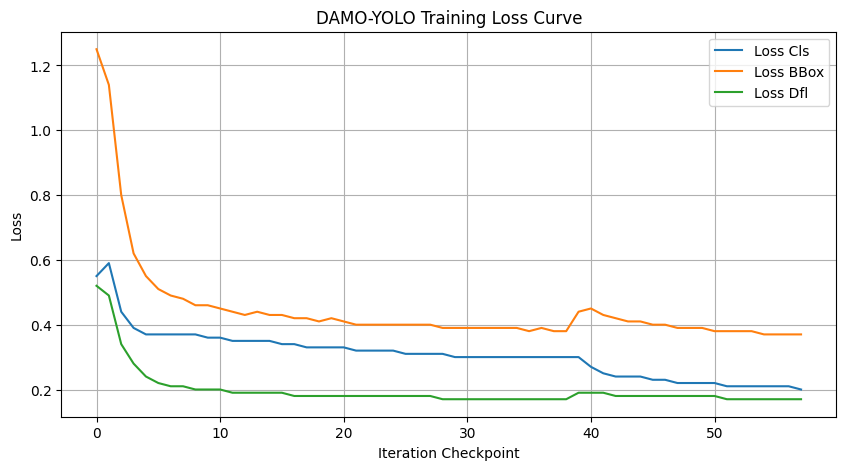

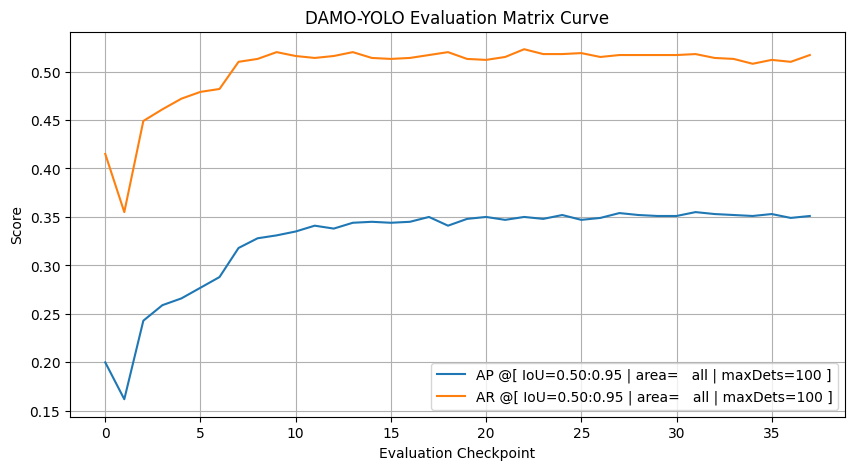

In [3]:
import re
import matplotlib.pyplot as plt
# change the path to the log of your latest train
log_path = latest_log 

# Regex pattern to extract values
pattern = re.compile(
    r"epoch: (\d+)/\d+, iter: (\d+)/\d+,.*?total_loss: ([\d.]+), loss_cls: ([\d.]+), loss_bbox: ([\d.]+), loss_dfl: ([\d.]+)"
)
# For AP @ IoU=0.50:0.95
ap_pattern = re.compile(
    r"Average Precision\s+\(AP\) @\[ IoU=0\.50:0\.95 \| area=\s+all \| maxDets=100 \] = ([\d.]+)"
)

# For AR @ IoU=0.50:0.95 | area=all | maxDets=100
ar_pattern = re.compile(
    r"Average Recall\s+\(AR\) @\[ IoU=0\.50:0\.95 \| area=\s+all \| maxDets=100 \] = ([\d.]+)"
)

epochs, iters, loss_list, loss_cls_list, loss_bbox_list, loss_dfl_list, ap_list, ar_list = [], [], [], [], [], [], [], []

with open(log_path, 'r', encoding='latin1') as f:
    for line in f:
        #print(line)
        match = pattern.search(line)
        if match:
            epoch_num = int(match.group(1))
            iter_num = int(match.group(2))
            loss = float(match.group(3))
            loss_cls = float(match.group(4))
            loss_bbox = float(match.group(5))
            loss_dfl = float(match.group(6))

            epochs.append(epoch_num)
            iters.append(iter_num)
            loss_list.append(loss)
            loss_cls_list.append(loss_cls)
            loss_bbox_list.append(loss_bbox)
            loss_dfl_list.append(loss_dfl)
        match = ap_pattern.search(line)
        if match:
            ap = float(match.group(1))
            ap_list.append(ap)
        match = ar_pattern.search(line)
        if match:
            ar = float(match.group(1))
            ar_list.append(ar)

# Plotting
x = range(len(epochs))
plt.figure(figsize=(10, 5))
plt.plot(x, loss_cls_list, label='Loss Cls')
plt.plot(x, loss_bbox_list, label='Loss BBox')
plt.plot(x, loss_dfl_list, label='Loss Dfl')
plt.xlabel('Iteration Checkpoint')
plt.ylabel('Loss')
plt.title('DAMO-YOLO Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plotting
x = range(len(ap_list))
plt.figure(figsize=(10, 5))
plt.plot(x, ap_list, label='AP @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]')
plt.plot(x, ar_list, label='AR @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]')
plt.xlabel('Evaluation Checkpoint')
plt.ylabel('Score')
plt.title('DAMO-YOLO Evaluation Matrix Curve')
plt.legend()
plt.grid(True)
plt.show()

#  Read the training log
Every checkpoint, the log prints current training status incluing Loss and learning rate(LR). <br>
and then current accuracy in AP and AR. In ideal scenario, training loss decreases and accuracy increases gradually throughout the training.  <br> 
When it comes to the end of training, training loss would still decreases slightly, while accuracy stops improving, and it should be already satisfactory.  <br>
  <br>
If training loss decreases and accuracy increases slowly, you may increase learning rate (eg double it)  <br>
If both training loss and accuracy flutuate violently, you may decrease learning rate (eg half it)  <br>
If accuracy is still improving at the end of training, you may increase number of epoch  <br>
If training loss decreases while accuracy stagnates or worsens before getting satisfactory accuracy, you should add more samples or implement stronger augmentation, and ensure the two datasets are alike  <br>
If both training loss and accuracy stagnates, and the accuracy is not satisfactory, you should consider choosing a more advanced or larger model <br>

# Validation plots

In [4]:
import os
from glob import glob

def get_latest_checkpoint(base_dir="./workdirs/damoyolo_tinynasL18_Ns-GC10/"):
  
    ckpt_files = glob(os.path.join(base_dir, "*.pth"))
    if not ckpt_files:
        return None

    latest_ckpt = max(ckpt_files, key=os.path.getmtime)
    return latest_ckpt
latest_ckpt = get_latest_checkpoint()

In [5]:
# Validation of certain pth
import argparse
import os
os.environ['MASTER_ADDR'] = 'localhost' 
os.environ['MASTER_PORT'] = '29001'
import torch
from loguru import logger

from damo.base_models.core.ops import RepConv
from damo.apis.detector_inference import inference
from damo.config.base import parse_config
from damo.dataset import build_dataloader, build_dataset
from damo.detectors.detector import build_ddp_model, build_local_model
from damo.utils import fuse_model, get_model_info, setup_logger, synchronize


def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def make_parser():
    parser = argparse.ArgumentParser('damo eval')

    # distributed
    parser.add_argument('--local_rank', type=int, default=0)
    parser.add_argument(
        '-f',
        '--config_file',
        default=None,
        type=str,
        help='pls input your config file',
    )
    parser.add_argument('-c',
                        '--ckpt',
                        default=None,
                        type=str,
                        help='ckpt for eval')
    parser.add_argument('--conf', default=None, type=float, help='test conf')
    parser.add_argument('--nms',
                        default=None,
                        type=float,
                        help='test nms threshold')
    parser.add_argument('--tsize',
                        default=None,
                        type=int,
                        help='test img size')
    parser.add_argument('--seed', default=None, type=int, help='eval seed')
    parser.add_argument(
        '--fuse',
        dest='fuse',
        default=True,
        action='store_true',
        help='Fuse conv and bn for testing.',
    )
    parser.add_argument(
        '--test',
        dest='test',
        default=False,
        action='store_true',
        help='Evaluating on test-dev set.',
    )  # TODO
    parser.add_argument(
        'opts',
        help='Modify config options using the command-line',
        default=None,
        nargs=argparse.REMAINDER,
    )
    return parser


def validate_damo(config_file, ckpt_file):
    # Handle distributed processing
    torch.distributed.init_process_group(
    backend='nccl',
    init_method='env://',
    world_size=1,
    rank=0
    )
    synchronize()
    args = make_parser().parse_args([])  # Use empty args list in Jupyter
    args.config_file = config_file #'/home/test/damo-yolo/configs/damoyolo_tinynasL18_Ns.py'  
    args.ckpt = ckpt_file
    
    device = 'cuda'
    config = parse_config(args.config_file)
    config.merge(args.opts)

    save_dir = os.path.join(config.miscs.output_dir, config.miscs.exp_name)

    if args.local_rank == 0:
        os.makedirs(save_dir, exist_ok=True)

    setup_logger(save_dir,
                 distributed_rank=args.local_rank,
                 mode='w')
    logger.info('Args: {}'.format(args))

    model = build_local_model(config, device)
    model.head.nms = True

    model.cuda(args.local_rank)
    model.eval()

    ckpt_file = args.ckpt
    logger.info('loading checkpoint from {}'.format(ckpt_file))
    loc = 'cuda:{}'.format(args.local_rank)
    ckpt = torch.load(ckpt_file, map_location=loc)
    new_state_dict = {}
    for k, v in ckpt['model'].items():
        k = k.replace('module', '')
        new_state_dict[k] = v
    model.load_state_dict(new_state_dict, strict=False)
    logger.info('loaded checkpoint done.')

    for layer in model.modules():
        if isinstance(layer, RepConv):
            layer.switch_to_deploy()

    infer_shape = sum(config.test.augment.transform.image_max_range) // 2
    logger.info('Model Summary: {}'.format(get_model_info(model,
        (infer_shape, infer_shape))))

    model = build_ddp_model(model, local_rank=args.local_rank)
    if args.fuse:
        logger.info('\tFusing model...')
        model = fuse_model(model)
    # start evaluate
    output_folders = [None] * len(config.dataset.val_ann)

    if args.local_rank == 0 and config.miscs.output_dir:
        for idx, dataset_name in enumerate(config.dataset.val_ann):
            output_folder = os.path.join(config.miscs.output_dir, 'inference',
                                         dataset_name)
            mkdir(output_folder)
            output_folders[idx] = output_folder

    val_dataset = build_dataset(config, config.dataset.val_ann, is_train=False)
    val_loader = build_dataloader(val_dataset,
                                  config.test.augment,
                                  batch_size=config.test.batch_size,
                                  num_workers=config.miscs.num_workers,
                                  is_train=False,
                                  size_div=32)

    for output_folder, dataset_name, data_loader_val in zip(
            output_folders, config.dataset.val_ann, val_loader):
        inference(
            model,
            data_loader_val,
            dataset_name,
            iou_types=('bbox', ),
            box_only=False,
            device=device,
            output_folder=output_folder,
        )

validate_damo(config_file='configs/damoyolo_tinynasL18_Ns-GC10.py', #your config.py
    ckpt_file=latest_ckpt,) #your model.pth

# the prediction will be saved in DAMO-YOLO/workdirs/inference/coco_2017_val

2025-07-11 15:17:11 | INFO     | __main__:97 - Args: Namespace(local_rank=0, config_file='configs/damoyolo_tinynasL18_Ns-GC10.py', ckpt='./workdirs/damoyolo_tinynasL18_Ns-GC10/latest_ckpt.pth', conf=None, nms=None, tsize=None, seed=None, fuse=True, test=False, opts=[])
2025-07-11 15:17:11 | INFO     | __main__:106 - loading checkpoint from ./workdirs/damoyolo_tinynasL18_Ns-GC10/latest_ckpt.pth
2025-07-11 15:17:11 | INFO     | __main__:114 - loaded checkpoint done.
2025-07-11 15:17:14 | INFO     | __main__:121 - Model Summary: backbone's params(M): 0.88, flops(G): 1.21, latency(ms): 1.153
neck's params(M): 0.50, flops(G): 0.37, latency(ms): 2.168
head's params(M): 0.01, flops(G): 0.02, latency(ms): 0.655
total latency(ms): 4.643, total flops(G): 1.59, total params(M): 1.39

2025-07-11 15:17:34 | INFO     | __main__:126 - 	Fusing model...
2025-07-11 15:17:34 | INFO     | torchvision.datasets.coco:38 - loading annotations into memory...
2025-07-11 15:17:34 | INFO     | torchvision.dataset

100%|##########| 4/4 [00:01<00:00,  3.16it/s]

2025-07-11 15:17:36 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.076001 (0.004513044979261315 s / img per device, on 1 devices)
2025-07-11 15:17:36 | INFO     | damo.apis.detector_inference:92 - Model inference time: 0:00:00.396739 (0.0008624755817910899 s / img per device, on 1 devices)
2025-07-11 15:17:36 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:42 - Preparing results for COCO format
2025-07-11 15:17:36 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:45 - Preparing bbox results


100%|##########| 4/4 [00:02<00:00,  1.95it/s]


2025-07-11 15:17:36 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:49 - Evaluating predictions
2025-07-11 15:17:37 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - Loading and preparing results...
2025-07-11 15:17:37 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:231 - DONE (t=0.38s)
2025-07-11 15:17:37 | INFO     | pycocotools.coco:366 - creating index...
2025-07-11 15:17:37 | INFO     | pycocotools.coco:366 - index created!
2025-07-11 15:17:37 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Running per image evaluation...
2025-07-11 15:17:37 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - Evaluate annotation type *bbox*
2025-07-11 15:17:38 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:236 - DONE (t=0.60s).
2025-07-11 15:17:38 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:237 - Accumulating evaluation results...
2025-07-11 15:17:38 | INFO     | damo.dataset.datasets.evalua

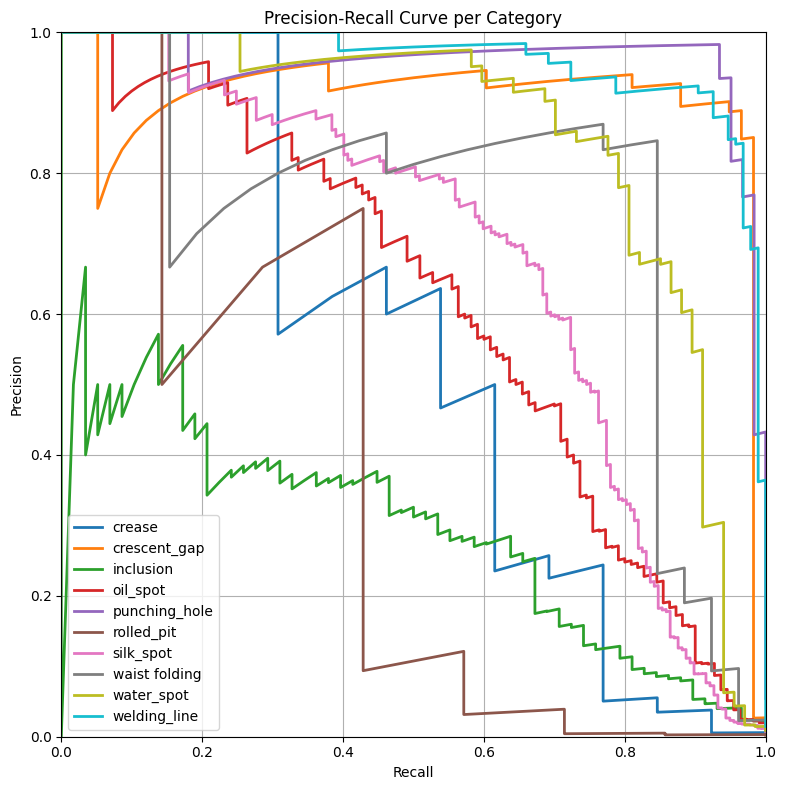

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import defaultdict
from sklearn.metrics import precision_recall_curve

truth_json = 'datasets/GC10-Det/valid/ann/annotations.json'
pred_json = 'workdirs/inference/coco_2017_val/bbox.json'
# Load COCO GT and prediction JSONs
coco_gt = COCO(truth_json)
with open(pred_json, 'r') as f:
    predictions = json.load(f)

# Get category ID to name mapping
categories = coco_gt.loadCats(coco_gt.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
cat_ids = list(cat_id_to_name.keys())

# Group predictions by category
preds_by_cat = defaultdict(list)
for pred in predictions:
    preds_by_cat[pred['category_id']].append(pred)

# Group GT annotations by category
gt_by_cat = defaultdict(list)
for ann in coco_gt.dataset['annotations']:
    gt_by_cat[ann['category_id']].append(ann)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

iou_threshold = 0.5
class_curves = {}

for cat_id in cat_ids:
    cat_id = cat_id
    y_true = []
    y_scores = []

    preds = sorted(preds_by_cat[cat_id], key=lambda x: -x['score'])
    gt_annots = gt_by_cat[cat_id]
    used = set()

    for pred in preds:
        pred_box = pred['bbox']
        image_id = pred['image_id']

        best_iou = iou_threshold
        best_gt_id = None
        for gt in gt_annots:
            if gt['image_id'] != image_id or gt['id'] in used:
                continue
            iou = compute_iou(pred_box, gt['bbox'])
            if iou > best_iou:
                best_iou = iou
                best_gt_id = gt['id']
        used.add(best_gt_id)
        y_true.append(1 if best_gt_id is not None else 0)
        y_scores.append(pred['score'])

    if len(set(y_true)) < 2:
        if sum(y_true) == 0:
            print(f"Class {cat_id_to_name[cat_id]} has ALL FALSE POSITIVES (no TP).")
        else:
            print(f"Class {cat_id_to_name[cat_id]} has ALL TRUE POSITIVES (no FP).")
        continue

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    class_curves[cat_id] = {
        'precision': precision,
        'recall': recall
    }

# Plotting Precision-Recall curves
plt.figure(figsize=(10, 8))
for cat_id, data in class_curves.items():
    plt.plot(data['recall'], data['precision'], label=cat_id_to_name[cat_id], linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Category')
plt.grid(True)
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.savefig('precision_recall_curves.png', bbox_inches='tight', dpi=300)
plt.show()

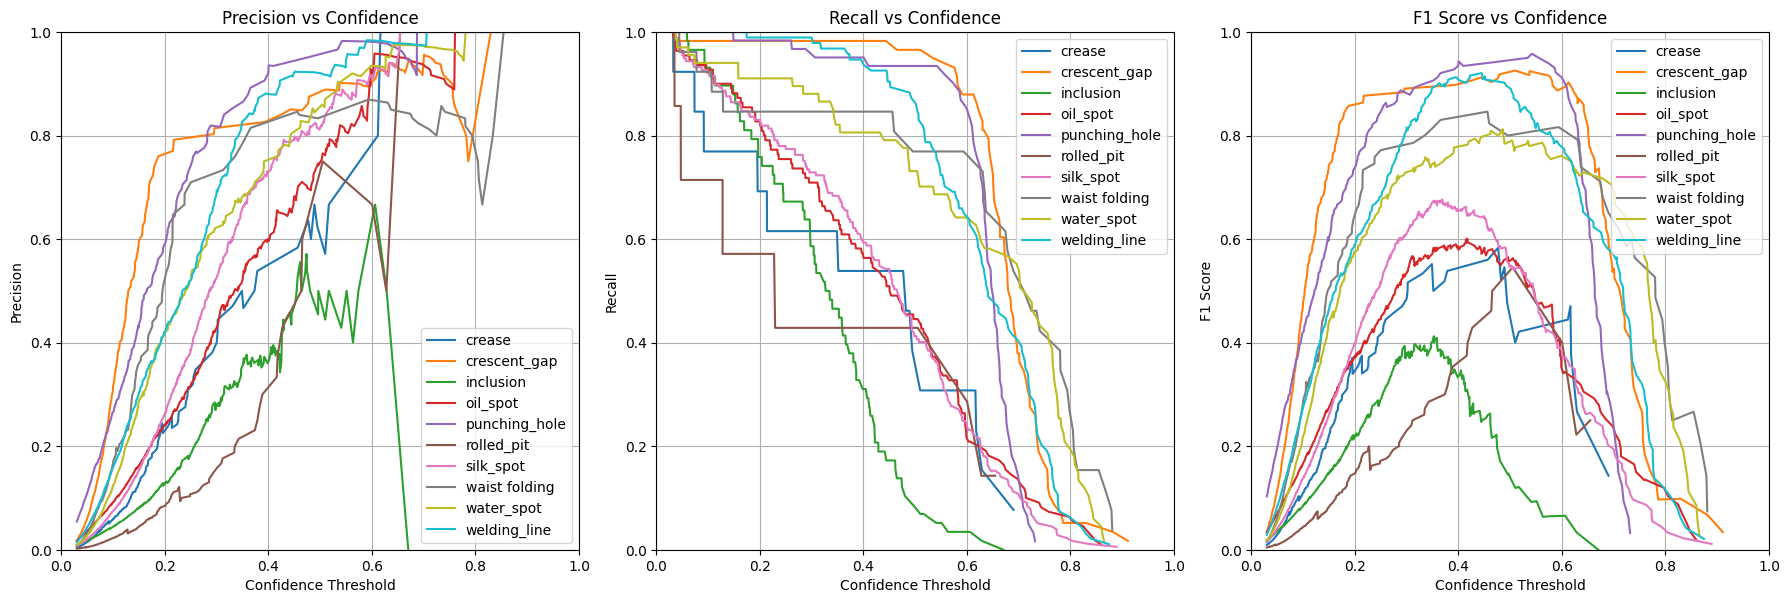

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import defaultdict
from sklearn.metrics import precision_recall_curve

# Load annotations and predictions
truth_json = 'datasets/GC10-Det/valid/ann/annotations.json'
pred_json = 'workdirs/inference/coco_2017_val/bbox.json'

# Load COCO GT and prediction JSONs
coco_gt = COCO(truth_json)
with open(pred_json, 'r') as f:
    predictions = json.load(f)

# Get category ID to name mapping
categories = coco_gt.loadCats(coco_gt.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
cat_ids = list(cat_id_to_name.keys())

# Group predictions by category
preds_by_cat = defaultdict(list)
for pred in predictions:
    preds_by_cat[pred['category_id']].append(pred)

# Group GT annotations by category
gt_by_cat = defaultdict(list)
for ann in coco_gt.dataset['annotations']:
    gt_by_cat[ann['category_id']].append(ann)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

iou_threshold = 0.5
class_curves = {}

for cat_id in cat_ids:
    y_true = []
    y_scores = []

    preds = sorted(preds_by_cat[cat_id], key=lambda x: -x['score'])
    gt_annots = gt_by_cat[cat_id]
    used = set()

    for pred in preds:
        pred_box = pred['bbox']
        image_id = pred['image_id']

        best_iou = iou_threshold
        best_gt_id = None
        for gt in gt_annots:
            if gt['image_id'] != image_id or gt['id'] in used:
                continue
            iou = compute_iou(pred_box, gt['bbox'])
            if iou > best_iou:
                best_iou = iou
                best_gt_id = gt['id']
        used.add(best_gt_id)
        y_true.append(1 if best_gt_id is not None else 0)
        y_scores.append(pred['score'])

    if len(set(y_true)) < 2:
        if sum(y_true) == 0:
            print(f"Class {cat_id_to_name[cat_id]} has ALL FALSE POSITIVES (no TP).")
        else:
            print(f"Class {cat_id_to_name[cat_id]} has ALL TRUE POSITIVES (no FP).")
        continue

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    class_curves[cat_id] = {
        'precision': precision,
        'recall': recall,
        'thresholds': thresholds
    }

# Plotting
plt.figure(figsize=(18, 6))

# 1. Precision-Confidence
plt.subplot(1, 3, 1)
for cat_id, data in class_curves.items():
    plt.plot(data['thresholds'], data['precision'][:-1], 
             label=cat_id_to_name[cat_id])
plt.xlabel('Confidence Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# 2. Recall-Confidence
plt.subplot(1, 3, 2)
for cat_id, data in class_curves.items():
    plt.plot(data['thresholds'], data['recall'][:-1], 
             label=cat_id_to_name[cat_id])
plt.xlabel('Confidence Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# 3. NEW: F1-Confidence
plt.subplot(1, 3, 3)
for cat_id, data in class_curves.items():
    # Calculate F1 scores
    precision = data['precision'][:-1]
    recall = data['recall'][:-1]
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    plt.plot(data['thresholds'], f1_scores, 
             label=cat_id_to_name[cat_id])

plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.tight_layout()
#plt.savefig('precision_recall_f1_confidence.png', bbox_inches='tight', dpi=300)
plt.show()


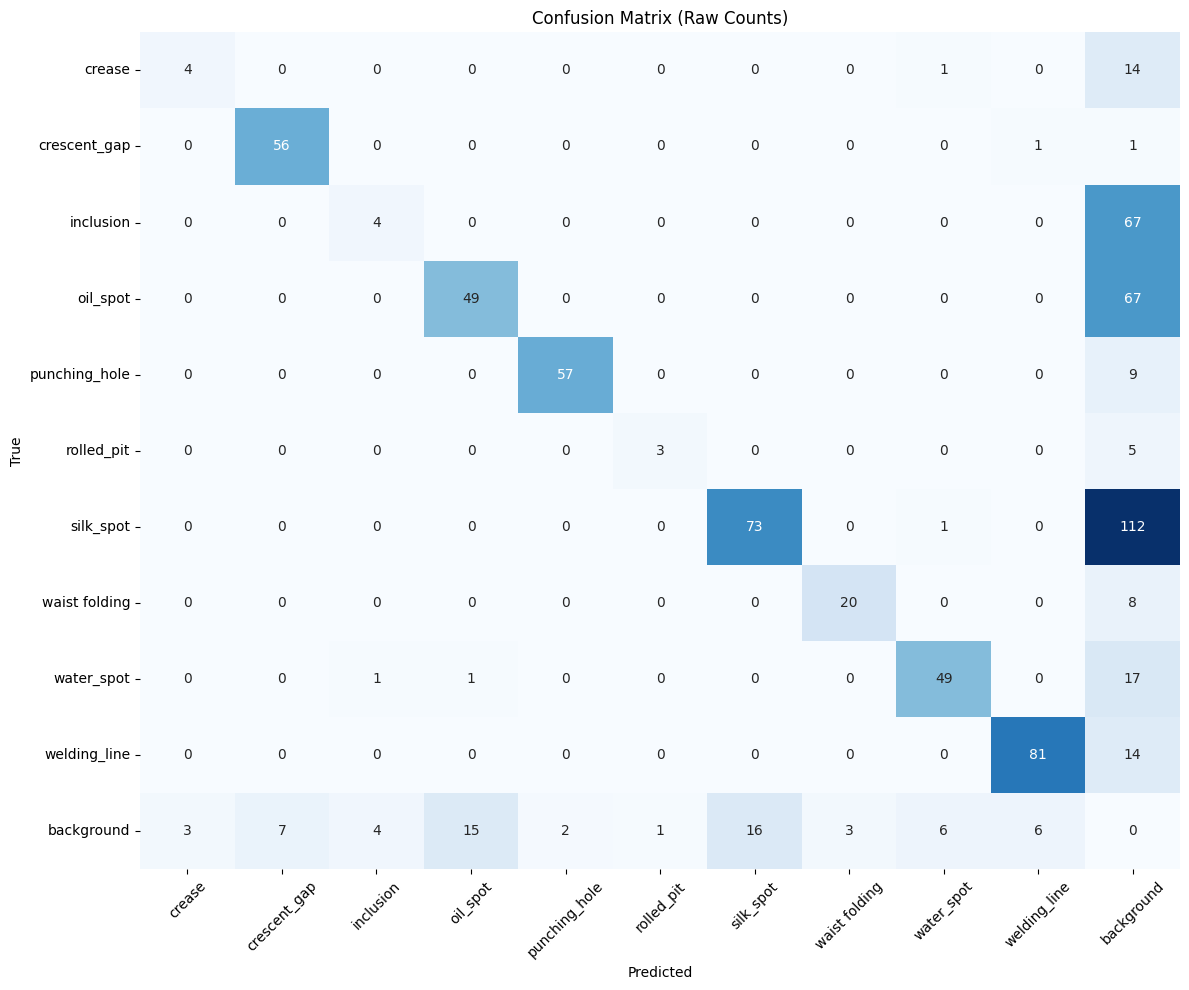

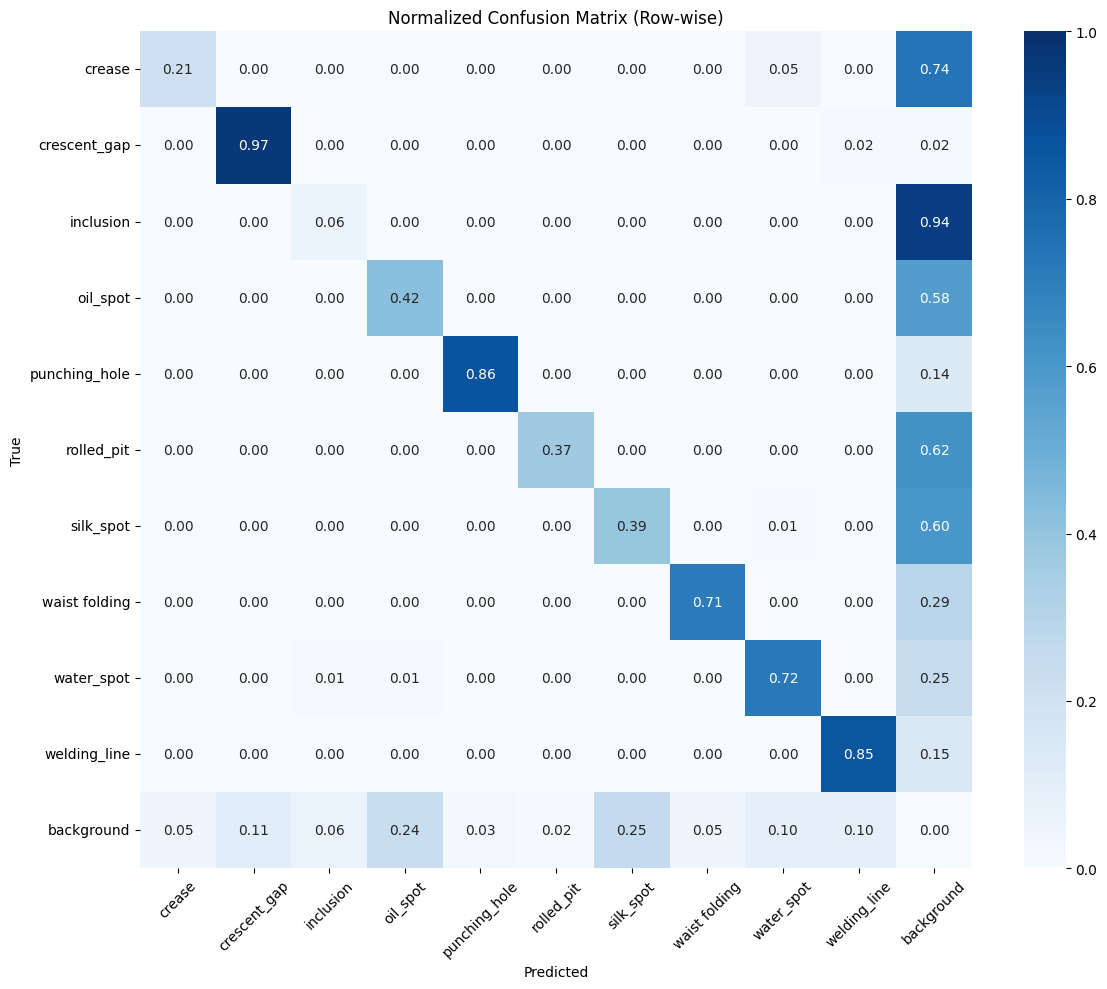

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycocotools import mask as maskUtils
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from sklearn.metrics import confusion_matrix
from collections import defaultdict

# Load ground truth and predictions
truth_json = 'datasets/GC10-Det/valid/ann/annotations.json'
pred_json = 'workdirs/inference/coco_2017_val/bbox.json'

# Load COCO API for ground truth
coco_gt = COCO(truth_json)

# Load the original predictions
with open(pred_json) as f:
    pred_data = json.load(f)
    
# filter out low confidence
threshold = 0.5
filtered_data = [pred_data_t for pred_data_t in pred_data if pred_data_t['score']>=threshold]
coco_dt = coco_gt.loadRes(filtered_data)

class_names = [coco_gt.loadCats(ids)[0]['name'] for ids in coco_gt.getCatIds()]
num_classes = len(class_names)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

def compute_confusion_matrix(coco_gt, coco_dt, iou_thresh=0.5):
    """
    Compute confusion matrix with IoU matching
    Returns: (raw_confusion_matrix, normalized_confusion_matrix)
    """
    num_classes = len(coco_gt.getCatIds())
    cm = np.zeros((num_classes+1, num_classes+1), dtype=int)  # +1 for background/FP
    
    for img_id in coco_gt.getImgIds():
        gt_anns = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=img_id))
        dt_anns = coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=img_id))
        
        # Track which GT boxes have been matched
        matched_gt = [False] * len(gt_anns)
        
        # Process detections sorted by confidence (highest first)
        dt_anns = sorted(dt_anns, key=lambda x: -x['score'])
        
        for dt in dt_anns:
            best_iou = iou_thresh
            best_idx = -1
            
            # Find best matching GT
            for i, gt in enumerate(gt_anns):
                if not matched_gt[i]:
                    iou = compute_iou(dt['bbox'], gt['bbox'])
                    if iou > best_iou:
                        best_iou = iou
                        best_idx = i
            
            if best_idx >= 0:  # True positive (of at least there is object, despite of classes)
                matched_gt[best_idx] = True
                gt_class = gt_anns[best_idx]['category_id']  
                dt_class = dt['category_id']   
                cm[gt_class, dt_class] += 1
            else:  # False positive
                dt_class = dt['category_id'] 
                cm[-1, dt_class] += 1  # Last row is for FP
        
        # Any unmatched GT are false negatives
        for i, matched in enumerate(matched_gt):
            if not matched:
                gt_class = gt_anns[i]['category_id'] 
                cm[gt_class, -1] += 1  # Last column is for FN
    
    # Normalized version (row-wise)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-6)
    
    return cm, cm_norm

# Compute matrices
cm_raw, cm_norm = compute_confusion_matrix(coco_gt, coco_dt)
class_names_with_bg = class_names + ['background']
# Plot raw confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_raw, annot=True, fmt='d', 
            xticklabels=class_names_with_bg, yticklabels=class_names_with_bg,
            cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Raw Counts)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('confusion_matrix_raw.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', 
            xticklabels=class_names_with_bg, yticklabels=class_names_with_bg,
            cmap='Blues', vmin=0, vmax=1)
plt.title('Normalized Confusion Matrix (Row-wise)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

# The counts lie inside the top left to bottom right diagonal are the correct predictions
# The others are wrong predictions, where the x-axis is the predicted label and the y-axis is true label
# eg, the top right corner are the samples that are actually crease but misclassified as background